In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from scipy.interpolate import PchipInterpolator

This is the first idea Björn suggested in 3/2025. Expansion in $Y_l^m$

Another set of basis functions could be something like $e^{im \phi} J_n(
 k r)$ if we directly parametrized 2d structure?

In [2]:
##############################################################################
# 1) BASE DENSITY FROM SPHERICAL HARMONICS
##############################################################################

def radial_envelope(r, alpha=0.05):
    """
    Gaussian radial envelope: exp(-alpha * r^2).
    """
    return np.exp(-alpha * r**2)

def angular_modulation(theta, phi, coeff_dict):
    """
    Compute the angular modulation as a weighted sum of the real parts of Y_l^m.
    """
    modulation = np.zeros_like(theta, dtype=np.float64)
    for (l, m), amp in coeff_dict.items():
        Ylm = sph_harm(m, l, phi, theta)
        modulation += amp * Ylm.real
    return modulation

def build_base_density_3D_general(X, Y, Z, coeff_dict, alpha=0.05, envelope_func=radial_envelope):
    """
    Build the base density field as:
       density_base = envelope(r) * exp( angular_modulation(theta, phi) )
    """
    r = np.sqrt(X**2 + Y**2 + Z**2)
    theta = np.where(r > 0, np.arccos(Z / r), 0.0)
    phi = np.arctan2(Y, X)
    phi = np.where(phi < 0, phi + 2*np.pi, phi)
    
    env = envelope_func(r, alpha)
    ang_mod = angular_modulation(theta, phi, coeff_dict)
    density_base = env * np.exp(ang_mod)
    return density_base


In [3]:

##############################################################################
# 2) NOISE FIELD WITH A NON-PARAMETRIC CONTINUOUS POWER SPECTRUM (3D)
##############################################################################

def generate_noise_field_3D(shape, L, sigma=2.0, seed=123):
    """
    Generate a 3D noise field using a non-parametric continuous power spectrum.
    
    Parameters:
      - shape: grid shape (Nx, Ny, Nz)
      - L: half-domain size (domain = [-L, L])
      - sigma: scales the overall level of the power spectrum (increases noise variance)
      - seed: random seed
      
    Returns:
      - noise_field: real 3D noise field.
    """
    rng = np.random.default_rng()
    Nx, Ny, Nz = shape

    # FFT frequencies (wavenumbers) for each dimension.
    kx = np.fft.fftfreq(Nx, d=(2*L / Nx)) * 2*np.pi
    ky = np.fft.fftfreq(Ny, d=(2*L / Ny)) * 2*np.pi
    kz = np.fft.fftfreq(Nz, d=(2*L / Nz)) * 2*np.pi
    Kx, Ky, Kz = np.meshgrid(kx, ky, kz, indexing='ij')
    Kmag = np.sqrt(Kx**2 + Ky**2 + Kz**2)
    k_max = Kmag.max()

    # -------------------------------
    # Define a non-parametric continuous power spectrum with a peak
    # -------------------------------
    k_peak = 4 * np.pi
    k_anchor = np.array([0.0, 0.5 * k_peak, k_peak, 2 * k_peak, k_max])
    S_anchor = np.array([1 * sigma**2, 1 * sigma**2, 4.0 * sigma**2, 0.1 * sigma**2, 0.000001 * sigma**2])
    
    log_S_anchor = np.log(S_anchor)
    pchip_interp = PchipInterpolator(k_anchor, log_S_anchor, extrapolate=True)
    
    # Exponential damping at high k.
    k_damp = k_peak  
    S_continuous = np.exp(pchip_interp(Kmag)) * np.exp(-Kmag / k_damp)
    
    # Fourier filter: square root of S_continuous.
    combined_filter = np.sqrt(S_continuous)
    
    # Generate random complex noise.
    noise = rng.normal(size=(Nx, Ny, Nz)) + 1j * rng.normal(size=(Nx, Ny, Nz))
    rho_k = noise * combined_filter
    noise_field = np.fft.ifftn(rho_k, axes=(0,1,2)).real
    return noise_field


In [4]:

##############################################################################
# 3) COMBINE BASE DENSITY WITH NOISE FLUCTUATIONS
##############################################################################

def combine_density_with_noise(base_density, noise_field, amplitude=2.0, max_exponent=20.0):
    """
    Combine the base density with noise:
         density = base_density * exp(amplitude * noise_field)
    The exponent is clamped to avoid overflow.
    """
    exponent = amplitude * noise_field
    exponent = np.clip(exponent, -max_exponent, max_exponent)
    return base_density * np.exp(exponent)


In [5]:

##############################################################################
# 4) INTEGRATION & MAIN
##############################################################################

def integrate_along_z(density_3D, z_vals):
    """
    Integrate the 3D density along the z-axis using the trapezoidal rule.
    """
    return np.trapz(density_3D, x=z_vals, axis=2)

def PlotConfiguration(seed=123, sigma_noise=10000):
    L = 1.0  # half-domain size 
    Nx, Ny, Nz = 128, 128, 64  # grid resolution
    
    x_vals = np.linspace(-L, L, Nx)
    y_vals = np.linspace(-L, L, Ny)
    z_vals = np.linspace(-L, L, Nz)
    X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')
    
    # Define spherical harmonic contributions. 9 parameters
    coeff_dict = {
        (3, 3): 3,
        (3, 2): 0,
        (3, 1): 0,
        (3, 0): 0,
        (3, -1): 0,
        (3, -2): 0,
        (3, -3): 0,
        (2, 2): 0,
        (2, 1): 0,
        (2, 0): 3,
        (2, -1): 0,
        (2, -2): 0,   
        (1, 0): 0,
        (1, 1): 0,
        (1, -1): 0,
        (0, 0): 0.1
    }
    
    # Build base density.
    base_density = build_base_density_3D_general(X, Y, Z, coeff_dict, alpha=2.)
    
    # Generate noise field with enhanced variance.
    noise_field = generate_noise_field_3D(shape=(Nx, Ny, Nz), L=L, sigma=sigma_noise, seed=seed)
    
    # Increase the noise amplitude to make fluctuations visible.
    density_3D = combine_density_with_noise(base_density, noise_field, amplitude=2.0, max_exponent=20.0)
    
    # Project along z.
    density_2D = integrate_along_z(density_3D, z_vals)
    
    # Plot the 2D projection.
    plt.figure(figsize=(7, 6))
    plt.imshow(density_2D.T, origin='lower', extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]],
               cmap='inferno', aspect='auto')
    plt.colorbar(label="Projected Density")
    plt.title("3D Density with Custom Spherical Harmonics & Enhanced Noise")
    plt.xlabel("x")
    plt.ylabel("y")
    

<Figure size 640x480 with 0 Axes>

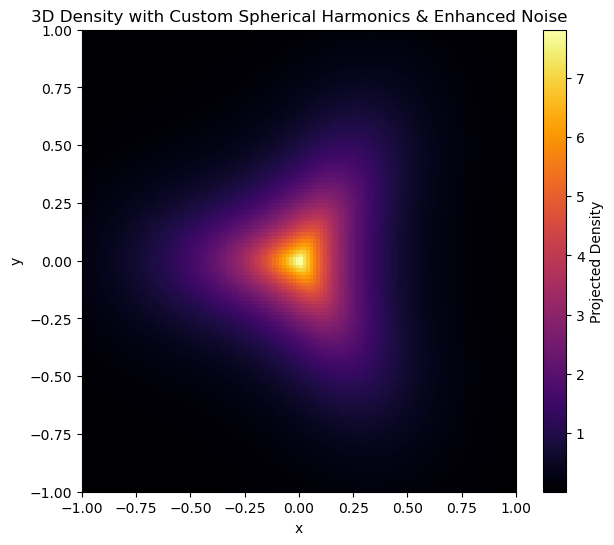

<Figure size 640x480 with 0 Axes>

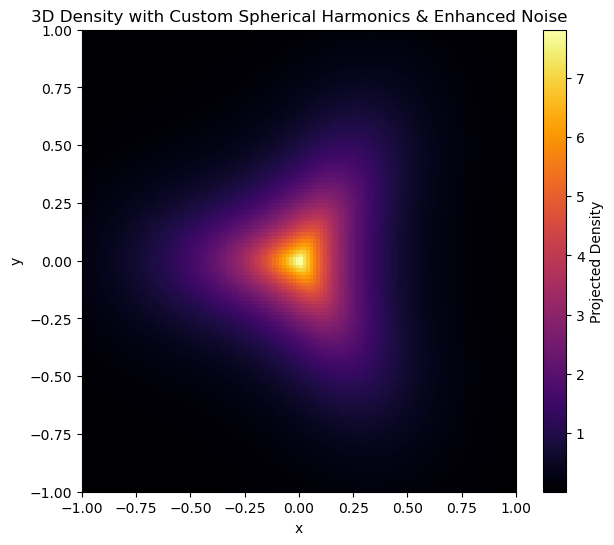

<Figure size 640x480 with 0 Axes>

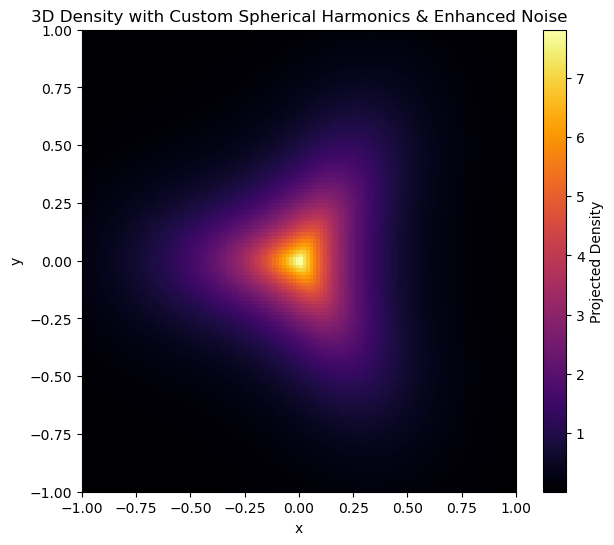

<Figure size 640x480 with 0 Axes>

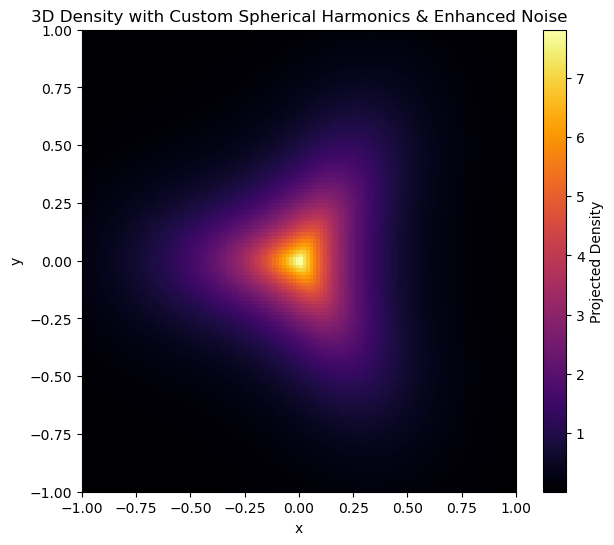

<Figure size 640x480 with 0 Axes>

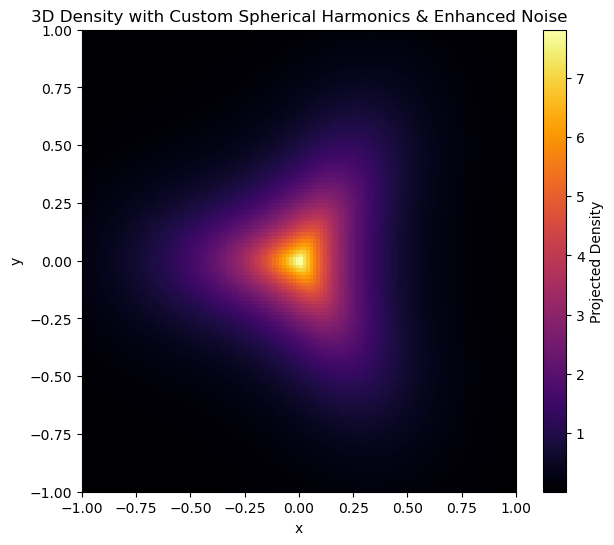

<Figure size 640x480 with 0 Axes>

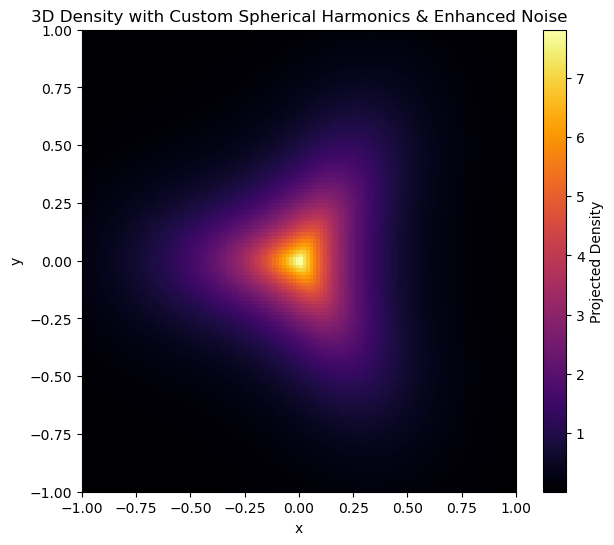

<Figure size 640x480 with 0 Axes>

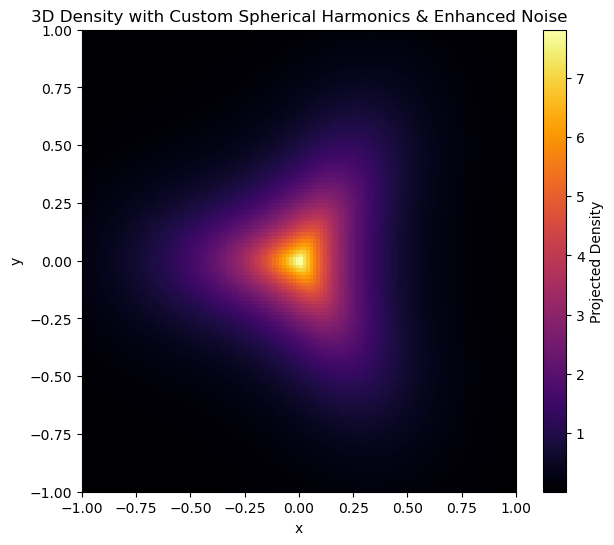

<Figure size 640x480 with 0 Axes>

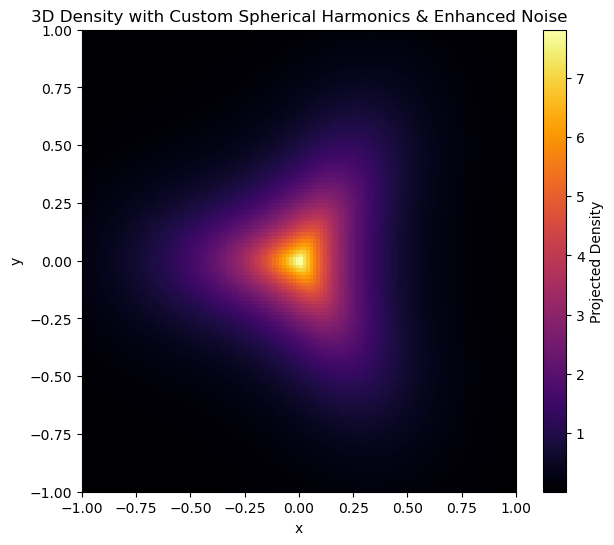

<Figure size 640x480 with 0 Axes>

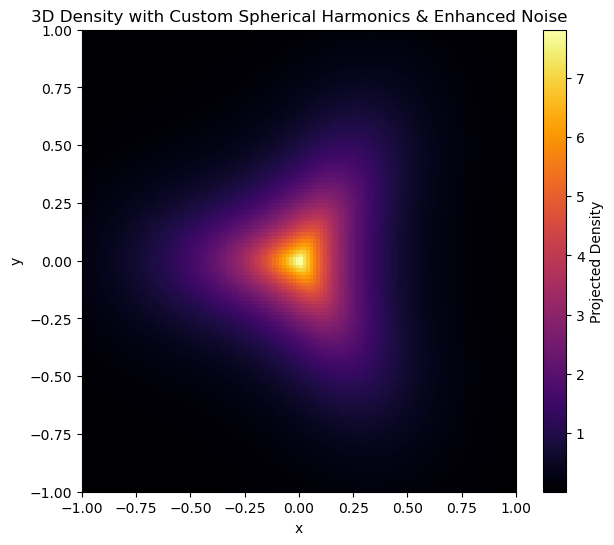

<Figure size 640x480 with 0 Axes>

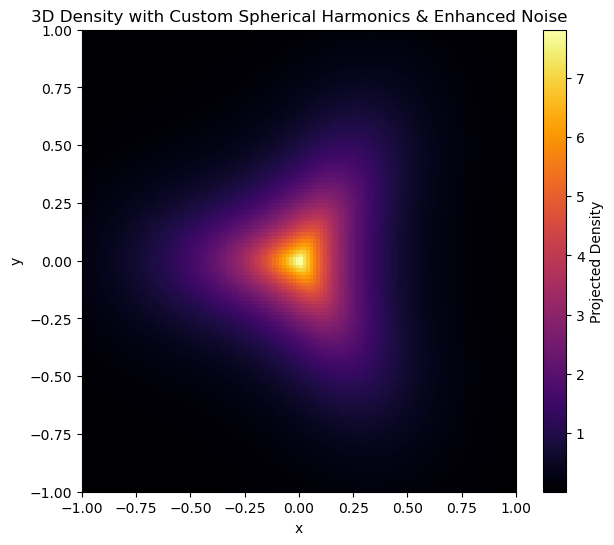

In [7]:
for s in range(10):
    fig=plt.figure()
    PlotConfiguration(seed=s,sigma_noise=0.001)